In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm

### Concept 1 - Why is CDF uniformly distributed?

CDF of any continuous random variable follows a standard uniform distribution.

The proof is as follows:
$$
\begin{gathered}
F_{Y}(y)=P(Y \leq y) \\
F_{Y}(y)=P(F_{X}(x) \leq y) \\
F_{Y}(y)=P\left(X \leq F^{-1}_{X}(y)\right) \\
F_{Y}(y)=F_{X}\left(F^{-1}_{X}(y)\right) \\
F_{Y}(y)=y
\end{gathered}
$$

The last equation is property of uniform distribution.
$$
Y \sim U(0, 1)
$$

Here we will test with normal distribution but you can try any other continuous distribution as well and it should work.

In [2]:
def pdf(x, mu, sigma):
    z = (x - mu) / sigma
    prob = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-z**2 / 2)
    return prob 

def get_cdf(data, n_pts):
    cdf = []
    X = np.linspace(0,1,n_pts)
    for x in X:
        percentile = np.sum(data<x) / len(data)
        cdf.append(percentile)
    return cdf    

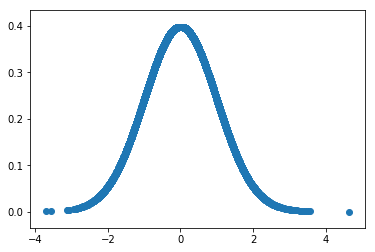

In [3]:
n_pts = 10000
data = np.random.normal(size=(n_pts,))
probs = list(map(lambda x: pdf(x, 0, 1), data))
cdf = get_cdf(data, n_pts)

plt.scatter(data, probs)
plt.show()

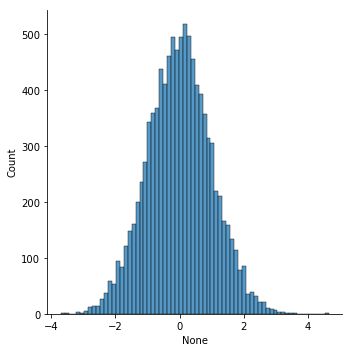

In [4]:
sns.displot(data)
plt.show()

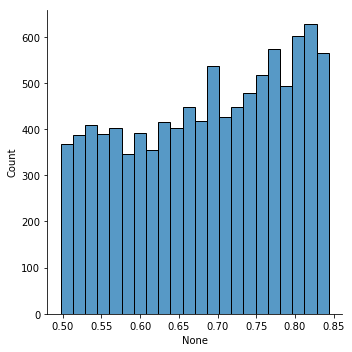

In [5]:
sns.displot(cdf)
plt.show()

### Concept 2 - How to sample random variables from a distribution?

We can use the above result to sample numbers from any continuous distribution. For example, given `mu` and `sigma`, if you want to generate normally distributed samples, you can calculate the inverse of CDF and use it. 

Note that $X$ is a random variable parametrized by $x$, which is a value that $X$ takes.

$$
\begin{gathered}
z=\frac{x-\mu}{\sigma} \\
\phi_{Z}(z)=y=P_{Y}(y) \\
z=\phi_{Z}^{-1}(y) \\
x=\sigma * \phi_{Z}^{-1}(y)+\mu 
\end{gathered}
$$

Now, as we know that $Y$ follows a standard uniform distribution, we can generate uniformly distributed random numbers and substitute for $y$ in the below equation to get normally distributed samples $x$ for random variable $X$.

$$
x=\sigma * \phi^{-1}(U_{Y}(y))+\mu
$$

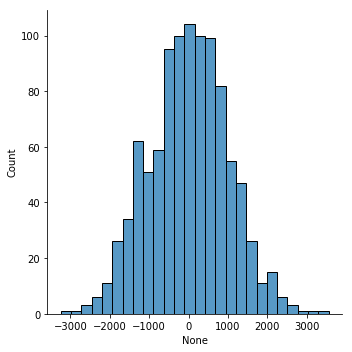

In [6]:
def generate_norm_samples(mu, sigma, n_pts):
    data = np.random.uniform(size=(n_pts,))
    X = list(map(lambda x: sigma * norm.ppf(x) + mu, data))
    return X

n_pts = 1000
mu = 50
sigma = 1000
X = generate_norm_samples(mu, sigma, n_pts)    
sns.displot(X)
plt.show()

The same procedure can be used to generate samples for any distribution. Let’s consider another example of generating samples for **exponential distribution**.

$$
\begin{gathered}
f(x)=\lambda e^{-\lambda x} \\
F_{X}(x)=1-e^{-\lambda x} \\
-\lambda x=\log \left(1-F_{X}(x)\right) \\
x=\frac{- \log \left(1-F_{x}(x)\right)}{\lambda}
\end{gathered}
$$

Since $F_{X}(x)$ follows uniform distribution,

$$
\begin{gathered}
x=\frac{- \log \left(1-U_{Y}(y)\right)}{\lambda}
\end{gathered}
$$

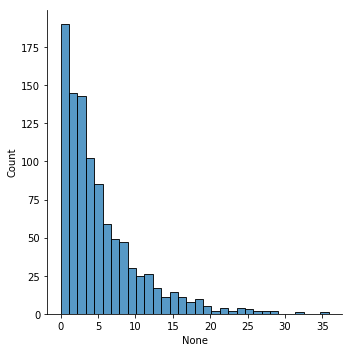

In [7]:
def generate_exp_samples(n_pts, lamda):
    U = np.random.uniform(size=(n_pts,))
    X = -np.log(1 - U) / lamda
    return X

lamda = 0.2 
X = generate_exp_samples(n_pts, lamda)
sns.displot(X)
plt.show()

#### Concept 3: Law of Large Numbers (LLN)

According to **Law of Large Numbers (LLN)**, if you conduct an experiment a number of times and compute a measure, the average of sample measures should be close to population measure. 

For an example, assume we want to find the centroid of a large number of points. However, we do not have enough computing power and memory to do it. So, instead of computing mean of entire data, we compute mean of a large number of bootsrapped samples and take their expectation. 

The expected value should get closer to the actual mean of all points and the variance of sample mean should decrease as more trials are performed.  

In [8]:
# population size
N = 100000 
# max value
max_value = 100

X=np.random.choice(np.arange(1,max_value), N, replace=True)
Y=np.random.choice(np.arange(1,max_value), N, replace=True)
Z=np.random.choice(np.arange(1,max_value), N, replace=True)

data=np.array([X,Y,Z]).transpose()
population_mean = np.mean(data,axis=0)
population_mean

array([49.96598, 50.02411, 49.82545])

In [9]:
def get_sample_measure(data, sample_size):
    return np.mean(np.random.choice(data, sample_size, replace=True))

def get_sampling_dist(data, sample_size, n_iters):
    return np.array(list(map(lambda x: get_sample_measure(data, sample_size), range(n_iters))))

def get_mean_var(sample):
    mean = np.mean(sample)
    var = np.var(sample)
    return mean, var

def get_expected_value(data, sample_size, n_iters):
    X = data[:,0]
    Y = data[:,1]
    Z = data[:,2]

    sample_x = get_sampling_dist(X, sample_size, n_iters)
    sample_y = get_sampling_dist(Y, sample_size, n_iters)
    sample_z = get_sampling_dist(Z, sample_size, n_iters)

    mean_x, var_x = get_mean_var(sample_x)
    mean_y, var_y = get_mean_var(sample_y)
    mean_z, var_z = get_mean_var(sample_z)

    exp_value = np.array([mean_x, mean_y, mean_z])
    total_var = (var_x + var_y + var_z) / n_iters
    return exp_value, total_var

In [10]:
# sample size
sample_size_pct = 0.1
sample_size = int(sample_size_pct * N) 

L2_norm = []
total_vars = []
for n_iters in tqdm(range(10, 2000, 10)):
    exp_value, total_var = get_expected_value(data, sample_size, n_iters)
    l2_norm = np.linalg.norm(population_mean - exp_value)
    L2_norm.append(l2_norm)
    total_vars.append(total_var)

100%|██████████| 199/199 [01:27<00:00,  2.28it/s]


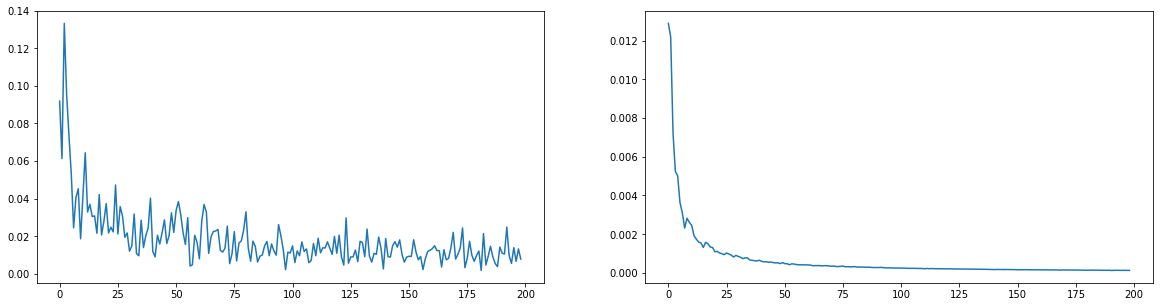

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(L2_norm)

plt.subplot(122)
plt.plot(total_vars)
plt.show()

#### Observations:
1. We see than the deviation between sample mean and population mean decreases with increasing number of trials
2. We see that variance converges with increasing number of trials